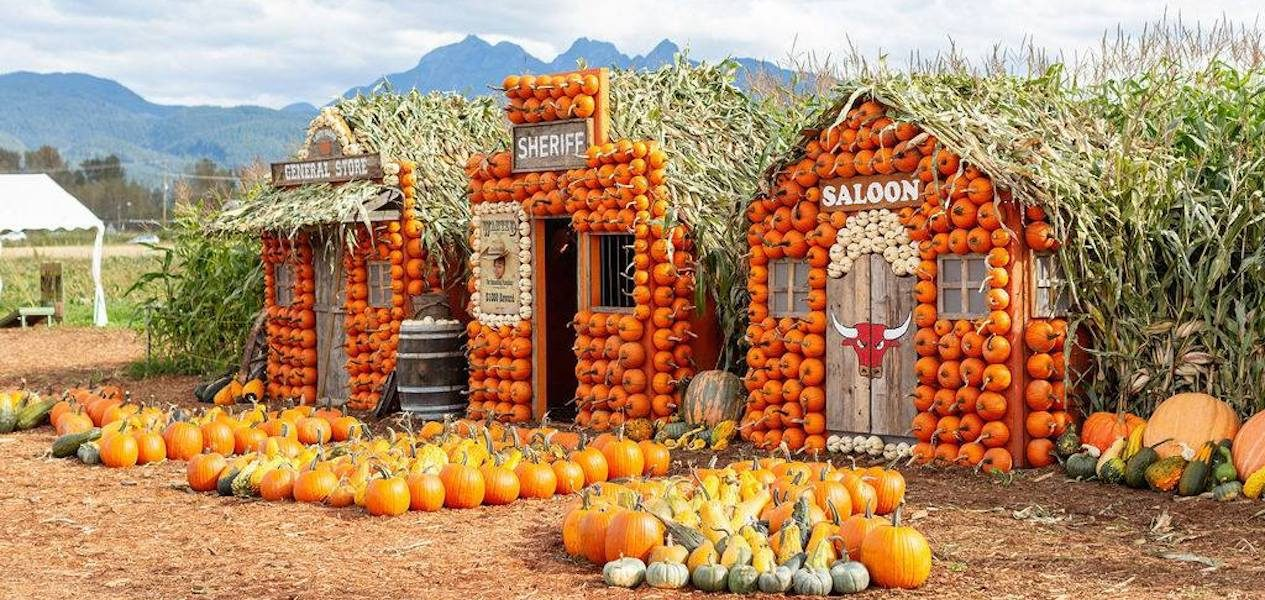
# Trick or Treat?

Mayor Ghouliani of Pumpkin Prefecture needs your help!

On Halloween, the residents usually gather in the town square to peacefully exchange candy with one another. However, over recent years the mayor has noticed an increase in some folks taking candy, but not exchanging some of their own - an act which has lead to increasing candy inequality.

Luckily for Pumpkin Prefecture the Data Analytics Practice at SiNesta have created an agent-based model to help them simulate policy interventions to increase the number of sharers.

## Potential target areas for policy

1. Cap how many residents can join in the candy exchange.
2. Change the budget for how many candy pieces each resident gets at the beginning of the night.
3. There is a public service broadcasting service to help educate the residents on candy sharing etiquette - this could be increased to make sure at the start of Halloween residents are more likely to be sharers.


## The model

Types of agent:

- Treaters (a.k.a sharers) - exchange one piece of candy if they bump into someone.
- Trickers - don't give away candy, but will take it!

Steps:

1. Everyone starts with the same amount of candy (`init_candy`)
2. A random proportion of the agents will start as sharers (according to `init_sharer_prop`)
3. Agents copy whether to share or not based off what those with the most candy around them do (e.g. switch to sharing if they see their neighbour has lots of candy and is a sharer)
4. Every now and again agents randomly decide to change whether they will share or not (probability according to `mutation_rate`)

## The mayor wants to know
- **What sort of conditions lead to everyone deciding to be a sharer?**
- **What conditions lead to candy equality?**


In [1]:
# Move to the abm_demo parent folder

In [2]:
cd ../..

/Users/india.kerlenesta/Projects/ds_meetings/tutorials/abm_demo


In [4]:
!pip install mesa

  Using cached Mesa-1.1.1-py3-none-any.whl (1.8 MB)

[notice] A new release of pip available: 22.2.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [5]:
import itertools

import mesa
import pandas as pd
import matplotlib.pyplot as plt

from abm_demo.examples.candy_model import *

## Parameter grid search

If you change the model:
1. Add new parameters to the grid search values (be careful to not add too many options since it can take a while to run!)
2. Add the parameter name to the parameters_of_interest (for plotting)

In [6]:
# 900 combinations
params = {
    "width": 10,
    "height": 10,
    "N": range(10, 100, 10), ## Change this
    "init_candy": range(1,5), ## Change this
    "init_sharer_prop": [0, 0.25, 0.5, 0.75, 1], ## Change this
    "mutation_rate": 0.001
}

# The parameters you are interesting in understanding for policy interventions
parameters_of_interest = ["N", "init_candy", "init_sharer_prop"]

results = mesa.batch_run(
    CandyModel,
    parameters=params,
    iterations=5, # Number of times to run this parameter combo 
    max_steps=100, # Number of steps to run the simulation for
    number_processes=1,
    data_collection_period=-1, ## Only collect the data for the last iteration
    display_progress=True,
)

100%|█████████████████████████████████████████| 900/900 [00:43<00:00, 20.70it/s]


In [7]:
# All the data (inc qualities for each agent in each iteration of each parameter combo)
results_df = pd.DataFrame(results)
print(len(results_df))
results_df.head(2)

45000


RunId  iteration  Step  width  height   N  init_candy  init_sharer_prop  \
0      0          0   100     10      10  10           1               0.0   
1      0          0   100     10      10  10           1               0.0   

   mutation_rate  Gini  proportion_sharers  AgentID  Wealth  Sharer  
0          0.001   0.0                 0.0        0       1   False  
1          0.001   0.0                 0.0        1       1   False

In [8]:
# Just care about the global qualities (which will be the same for all agents)
# so can just get the data from agent 0
model_results_df = results_df[(results_df.AgentID == 0)]
print(len(model_results_df))

900


## Types of simulation outcomes

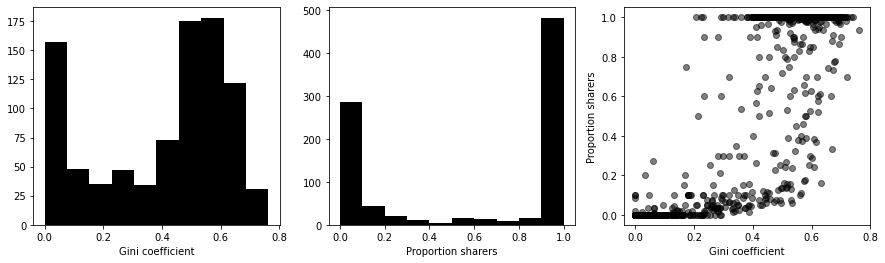

In [9]:
gini_values = model_results_df.Gini.values
prop_sharers_values = model_results_df.proportion_sharers.values

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))

ax1.hist(gini_values, color='k');
ax1.set_xlabel("Gini coefficient")
ax2.hist(prop_sharers_values, color='k');
ax2.set_xlabel("Proportion sharers");

ax3.scatter(gini_values, prop_sharers_values, alpha=0.5, c='k')
ax3.set_xlabel("Gini coefficient")
ax3.set_ylabel("Proportion sharers");

## 1. What sort of conditions lead to everyone deciding to be a sharer?

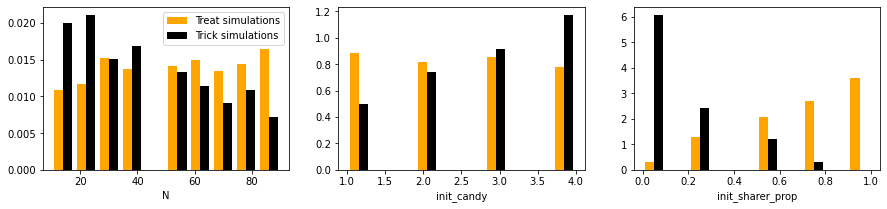

In [10]:
trick_simulations = model_results_df[model_results_df['proportion_sharers']==0]
treat_simulations = model_results_df[model_results_df['proportion_sharers']==1]
    
fig, axs = plt.subplots(1,3, figsize=(15,3))

for i, col_name in enumerate(parameters_of_interest):
    axs[i].hist(
        [treat_simulations[col_name],
         trick_simulations[col_name]],
        density=True, label=['Treat simulations', 'Trick simulations'], color=['orange','k'])
    axs[i].set_xlabel(col_name)
    if i==0:
        axs[i].legend()

## 2. What conditions lead to candy equality?

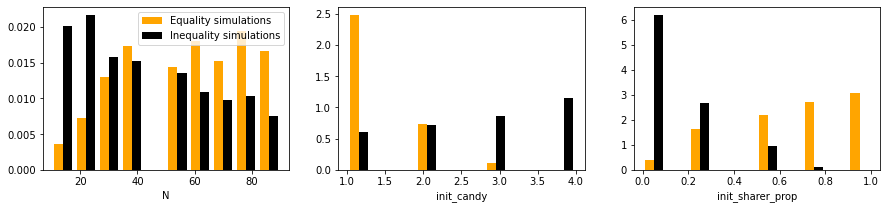

In [11]:
equality_simulations = model_results_df[model_results_df['Gini']>0.6]
inequality_simulations = model_results_df[model_results_df['Gini']<0.2]
    
fig, axs = plt.subplots(1,3, figsize=(15,3))

for i, col_name in enumerate(parameters_of_interest):
    axs[i].hist(
        [equality_simulations[col_name],
         inequality_simulations[col_name]],
        density=True, label=['Equality simulations', 'Inequality simulations'], color=['orange','k'])
    axs[i].set_xlabel(col_name)
    if i==0:
        axs[i].legend()